# Introduction

## Main Question
How do variations in air pollution levels impact weather conditions in London from 2008 to 2018?

## Description
This project examines the relationship between London's air pollution levels and weather from 2008 to 2018.
The goal is to examine how changes in the weather might affect air quality by using historical weather data along
with pollution measurements. The project integrates data from the London Datastore and Kaggle to investigate
relationships between weather patterns and pollution indices, including its impact of temperature on gasses and
particle matter. Our goal is to get a deeper understanding of the environmental dynamics in metropolitan London
through this study.
sulfurdioxide

The analysis utilizes two primary datasets: London Weather Data from Kaggle and Air Quality Levels from the London Datastore. The weather dataset includes daily measurements of temperature, humidity, and precipitation from a station near Heathrow Airport. The air quality dataset provides readings on pollutants like Nitric Oxide, Nitrogen Dioxide, and Particulate Matter from various monitoring sites across London. Both datasets are integrated using their common temporal features, enabling a detailed analysis of the correlations between air quality and weather conditions.


In [40]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots

In [41]:
# Function to load data from SQLite database
def load_data(db_path, query):
    conn = sqlite3.connect(db_path)
    df = pd.read_sql_query(query, conn)
    conn.close()
    return df

# Load all necessary data
weather_data = load_data('../data/London_weather.sqlite', 'SELECT * FROM weather_data')
pollution_data = load_data('../data/London_pollution.sqlite', 'SELECT * FROM time_of_day_data')
combined_data = load_data('../data/combined_London_climate.sqlite', 'SELECT * FROM combined_weather_data')

# Convert 'date' column to datetime format for combined data
combined_data['date'] = pd.to_datetime(combined_data['date'])

In [42]:
# Display first few rows of each dataset
print("Weather Data Head:")
display(weather_data.head())
print("Pollution Data Head:")
display(pollution_data.head())

# Print column names for both datasets
print("Weather Data Columns:")
print(weather_data.columns.tolist())
print("Pollution Data Columns:")
print(pollution_data.columns.tolist())

Weather Data Head:


,date,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure
0,2008-01-01,8.0,0.0,13.0,9.1,7.8,6.6,0.4,102260.0
1,2008-02-01,1.0,6.0,68.0,8.7,5.9,3.1,0.0,99970.0
2,2008-03-01,5.0,5.5,108.0,12.9,8.9,4.9,0.0,100730.0
3,2008-04-01,4.0,7.5,178.0,15.8,11.4,6.9,0.0,101870.0
4,2008-05-01,6.0,4.6,175.0,15.2,11.0,6.9,4.0,100650.0


Pollution Data Head:


,date,Roadside_NO2,Roadside_NOx,Roadside_O3,Roadside_PM10,Roadside_PM2_5,Roadside_SO2,Background_NO2,Background_NOx,Background_O3,Background_PM10,Background_PM2_5,Background_SO2
0,2008-01-01,60.838710,NaN,30.645161,26.322581,14.225806,4.870968,41.064516,NaN,41.129032,17.032258,NaN,3.483871
1,2008-02-01,72.517241,NaN,26.689655,44.551724,28.137931,10.620690,50.827586,NaN,37.724138,32.689655,NaN,8.793103
2,2008-03-01,58.129032,NaN,46.870968,24.290323,12.000000,4.580645,35.161290,NaN,61.806452,15.935484,NaN,2.290323
3,2008-04-01,60.833333,NaN,49.733333,29.766667,18.833333,5.200000,35.000000,NaN,69.266667,20.433333,NaN,3.400000
4,2008-05-01,63.967742,NaN,64.903226,33.967742,22.612903,5.612903,35.387097,NaN,85.774194,26.870968,13.0,4.677419


Weather Data Columns:
['date', 'cloud_cover', 'sunshine', 'global_radiation', 'max_temp', 'mean_temp', 'min_temp', 'precipitation', 'pressure']
Pollution Data Columns:
['date', 'Roadside_NO2', 'Roadside_NOx', 'Roadside_O3', 'Roadside_PM10', 'Roadside_PM2_5', 'Roadside_SO2', 'Background_NO2', 'Background_NOx', 'Background_O3', 'Background_PM10', 'Background_PM2_5', 'Background_SO2']


# Analysis

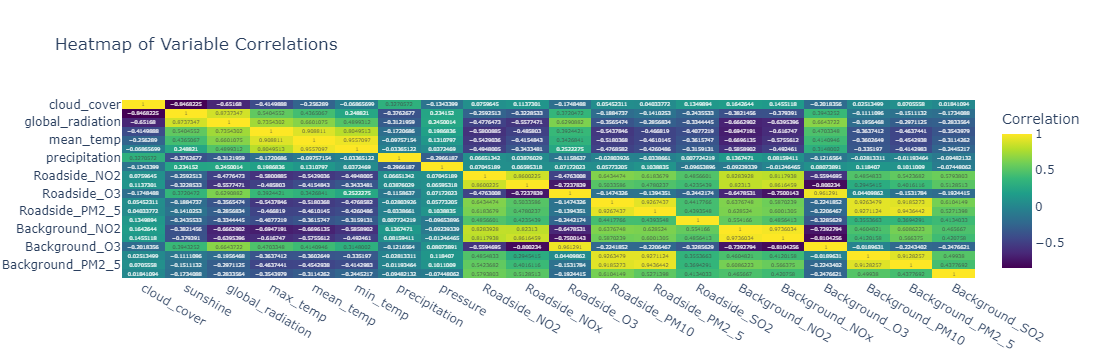

In [43]:
# Remove the 'date' column before calculating the correlation matrix
df_numeric = combined_data.drop(columns='date')
# Generate a heatmap to visualize the correlation matrix
corr_matrix = df_numeric.corr()
fig = px.imshow(corr_matrix, 
                text_auto=True, 
                aspect="auto", 
                color_continuous_scale='Viridis', 
                labels=dict(color="Correlation"),
                title="Heatmap of Variable Correlations")
fig.show()

The heatmap of variable correlations visualizes that mean temperature negatively correlates with NO2 levels, suggesting warmer temperatures help reduce NO2 due to atmospheric dispersion. Positive correlations between mean temperature and global radiation confirm expected trends that higher temperatures coincide with clearer skies and more solar radiation. Meanwhile, precipitation and cloud cover display mixed effects on pollutants, with precipitation often negatively correlating with pollutants like SO2, indicating rain may help remove these from the air.

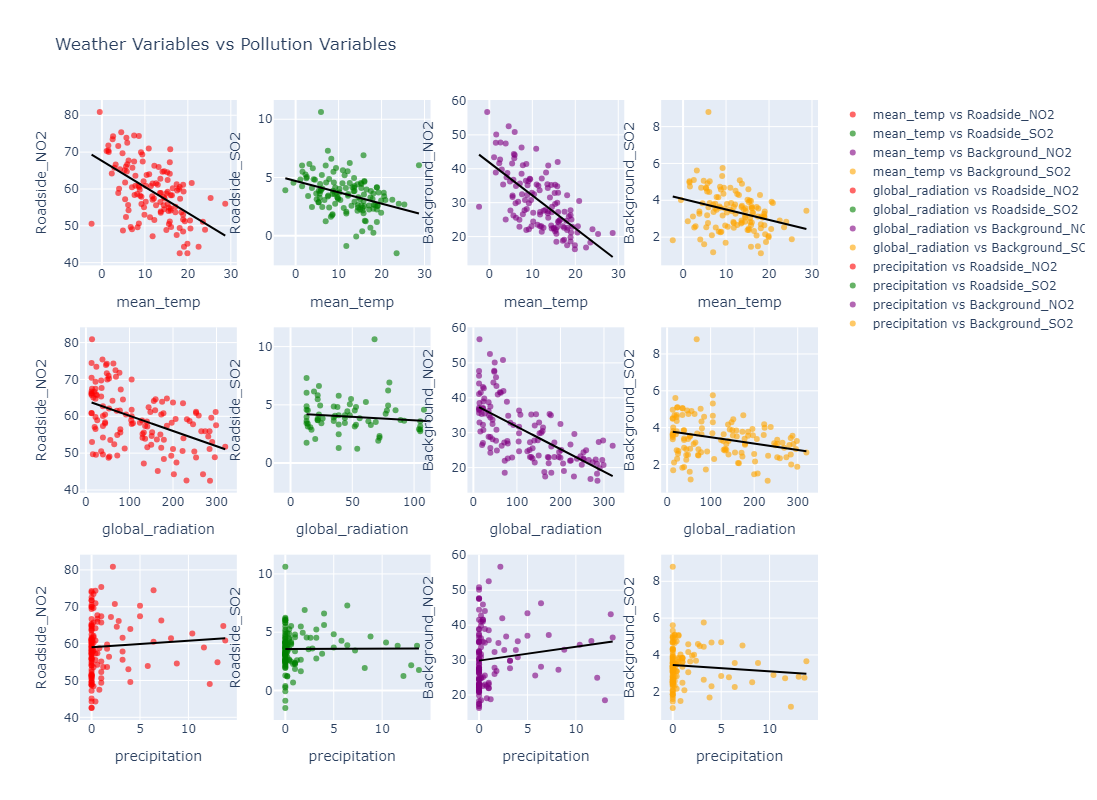

In [51]:
# Define the variables to compare
weather_vars = ['mean_temp', 'global_radiation', 'precipitation']
pollution_vars = ['Roadside_NO2', 'Roadside_SO2', 'Background_NO2', 'Background_SO2']

weather_color = 'blue'  
pollution_colors = {
    'Roadside_NO2': 'red',
    'Roadside_SO2': 'green',
    'Background_NO2': 'purple',
    'Background_SO2': 'orange'
}


fig = make_subplots(rows=len(weather_vars), cols=len(pollution_vars), shared_xaxes=False, shared_yaxes=False)

def add_trace_with_trendline(fig, x, y, x_label, y_label, row, col, scatter_color, trendline_color):
    # Scatter plot with specific color for each variable
    fig.add_trace(go.Scatter(x=x, y=y, mode='markers', name=f'{x_label} vs {y_label}',
                             marker=dict(color=scatter_color, opacity=0.6)), row=row, col=col)
    
    # Trendline
    trendline = px.scatter(x=x, y=y, trendline="ols").update_traces(line=dict(color=trendline_color), selector=dict(type='scatter')).data[1]
    fig.add_trace(trendline, row=row, col=col)

for i, weather_var in enumerate(weather_vars):
    for j, pollution_var in enumerate(pollution_vars):
        # Use specific colors for pollution variables from the map
        scatter_color = pollution_colors[pollution_var]
        add_trace_with_trendline(fig, combined_data[weather_var], combined_data[pollution_var], weather_var, pollution_var, 
                                 row=i+1, col=j+1, scatter_color=scatter_color, trendline_color='black')

        fig.update_xaxes(title_text=weather_var, row=i+1, col=j+1)
        fig.update_yaxes(title_text=pollution_var, row=i+1, col=j+1)

fig.update_layout(height=800, width=1100, title_text="Weather Variables vs Pollution Variables")
fig.show()

The visualized scatter plots demonstrate the relationship between various weather conditions and pollution levels. There's a clear negative correlation between mean temperature and both NO2 and SO2 across different contexts, suggesting that higher temperatures may facilitate the reduction of these pollutants due to enhanced atmospheric dispersion and possibly chemical degradation. Similarly, global radiation shows a strong negative correlation with NO2 and SO2, reinforcing that increased solar radiation may contribute to the breakdown of these pollutants. Conversely, precipitation displays a variable relationship with pollutants: while it generally shows a negative correlation with SO2, indicating rain's effectiveness in washing out soluble pollutants from the atmosphere, its impact on NO2 is less pronounced, suggesting that NO2's atmospheric behavior is less influenced by precipitation. 

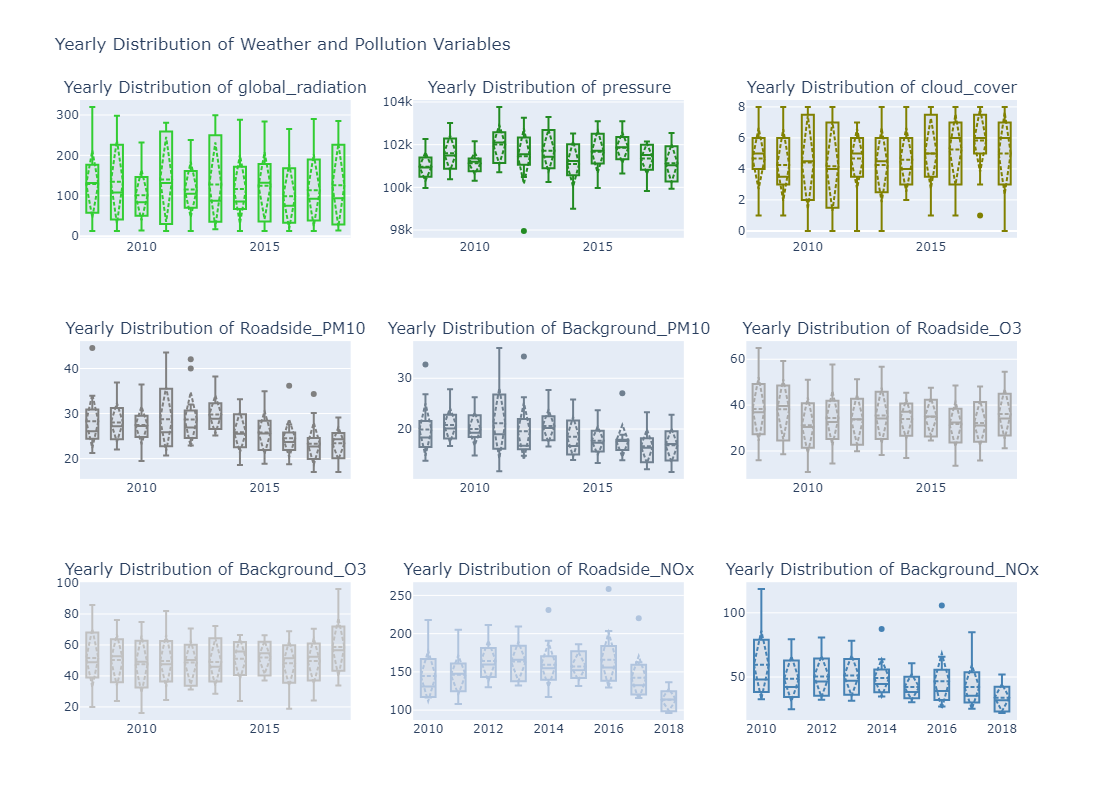

In [52]:
combined_data['year'] = combined_data['date'].dt.year

# Define additional weather and pollution variables for boxplots
variables_to_plot = [
    'global_radiation', 'pressure', 'cloud_cover',    # Weather variables
    'Roadside_PM10', 'Background_PM10', 'Roadside_O3', # Pollution variables row 2
    'Background_O3', 'Roadside_NOx', 'Background_NOx'  # Pollution variables row 3
]

colors = {
    'global_radiation': 'limegreen',
    'pressure': 'forestgreen',
    'cloud_cover': 'olive',   
    'Roadside_PM10': 'gray',
    'Background_PM10': 'slategray',
    'Roadside_O3': 'darkgray',
    'Background_O3': 'silver',
    'Roadside_NOx': 'lightsteelblue',
    'Background_NOx': 'steelblue'
}

# Setting up the plot with subplots to accommodate all variables
fig = make_subplots(rows=3, cols=3, subplot_titles=[f'Yearly Distribution of {var}' for var in variables_to_plot])

# Adding box plots, accounting for rows and columns
row_col_index = [(1, 1), (1, 2), (1, 3),  # Weather variables in row 1
                 (2, 1), (2, 2), (2, 3),  # Pollution variables row 2
                 (3, 1), (3, 2), (3, 3)]  # Pollution variables row 3

for (row, col), var in zip(row_col_index, variables_to_plot):
    data = combined_data[['year', var]].dropna()
    fig.add_trace(
        go.Box(
            y=data[var], 
            x=data['year'],
            name=var,
            marker_color=colors[var],
            fillcolor='rgba(0,0,0,0.05)',  # Light translucent fill
            line=dict(width=2, color=colors[var]),  # Line settings
            boxmean='sd'  # Show the mean and standard deviation of the distribution
        ),
        row=row, col=col
    )

fig.update_layout(
    height=800, width=1100,
    title_text="Yearly Distribution of Weather and Pollution Variables",
    showlegend=False
)

fig.show()

The provided boxplots illustrate the annual variations in weather and pollution variables in London from 2008 to 2018. Weather metrics such as global radiation and pressure show distinct yearly patterns with some fluctuations, indicating typical seasonal variations. For pollution variables, PM10 and ozone (O3) levels display consistency over the years but with notable spikes, highlighting episodic pollution events possibly triggered by specific weather conditions or human activities. Additionally, the NOx levels in both roadside and background locations show similar trends, reflecting persistent exposure to nitrogen oxides amidst urban traffic emissions.

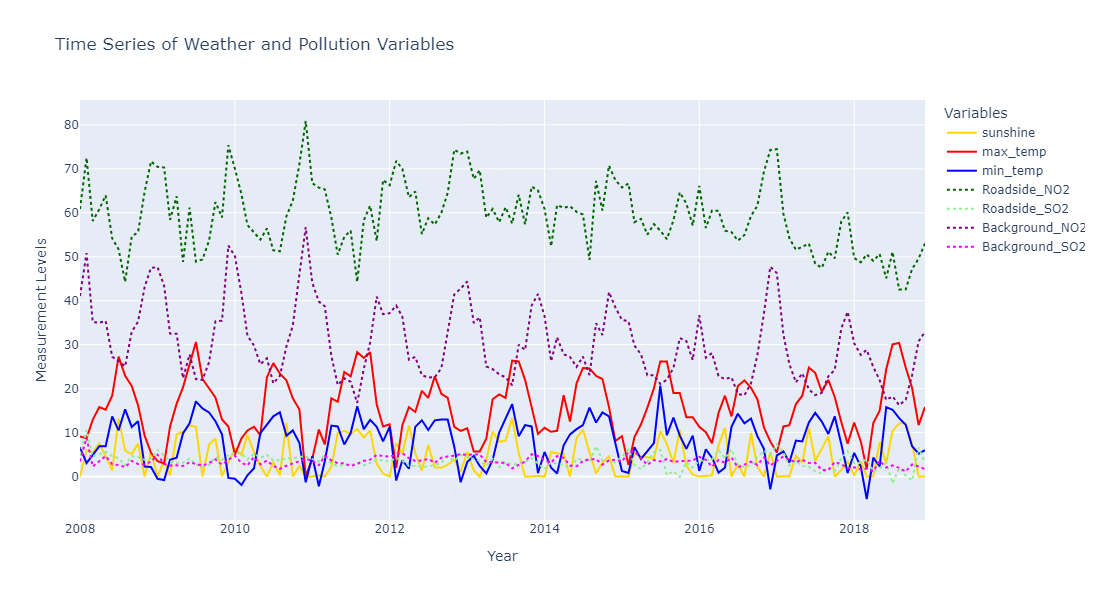

In [48]:
combined_data['date'] = pd.to_datetime(combined_data['date'])
combined_data['year'] = combined_data['date'].dt.year

# Define weather and pollution variables for trend plots
weather_vars = ['sunshine', 'max_temp', 'min_temp']
pollution_vars = ['Roadside_NO2', 'Roadside_SO2', 
                  'Background_NO2', 'Background_SO2']

colors = {
    'sunshine': 'gold',
    'max_temp': 'red',
    'min_temp': 'blue',
    'Roadside_NO2': 'darkgreen',
    'Roadside_SO2': 'lightgreen',
    'Background_NO2': 'purple',
    'Background_SO2': 'magenta'
}

fig = go.Figure()
# Add traces for weather variables
for var in weather_vars:
    fig.add_trace(
        go.Scatter(x=combined_data['date'], y=combined_data[var], mode='lines', name=var,
                   line=dict(color=colors[var], width=2))
    )

# Add traces for pollution variables
for var in pollution_vars:
    fig.add_trace(
        go.Scatter(x=combined_data['date'], y=combined_data[var], mode='lines', name=var,
                   line=dict(color=colors[var], width=2, dash='dot'))  # Use dash for pollution for distinction
    )


fig.update_layout(
    height=600, width=1100, 
    title_text="Time Series of Weather and Pollution Variables",
    xaxis_title='Year',
    yaxis_title='Measurement Levels',
    legend_title='Variables'
)

fig.show()

This time series graph presents the variations in weather and pollution in London over a span from 2008 to 2018. It displays distinct seasonal patterns in weather variables such as sunshine, maximum temperature, and minimum temperature, with noticeable peaks during the summer months each year. The temperatures are tracked through max and min values, where maximum temperatures are consistently higher, underscoring the typical warmth of summer compared to cooler winter periods. In contrast, pollution variables like NO2 and SO2, measured at both roadside and background levels, show variations that don't follow a clear seasonal trend and seem to respond more to changes in urban activity and traffic. 

# Conclusions
This study has provided a comprehensive analysis of the relationship between air pollution and weather conditions in London from 2008 to 2018. Our findings confirm that weather patterns significantly influence pollution levels; higher temperatures are generally associated with lower concentrations of NO2 and SO2, suggesting that warmer weather could help to reduce air pollutants more effectively, likely due to increased atmospheric mixing.
Additionally, the study explores the impact of solar radiation on air quality. Increased levels of global radiation correlated with reduced pollutant concentrations, reinforcing the idea that sunlight not only chemically breaks down certain pollutants but also contributes to atmospheric conditions conducive to dispersing pollutants. While some pollutants like NO2 showed clear correlations with temperature changes, others such as PM10 exhibited more variable patterns that did not consistently align with specific weather conditions. 
In conclusion, this study highlights the significant yet complex role that weather conditions play in influencing air pollution levels, underscoring the importance of understanding these dynamics for developing effective environmental policies in urban settings. Despite these insights, the study faces limitations due to the exclusion of real-time traffic data and specific emission sources, which are critical factors in urban pollution dynamics. Continued research is essential to fully mitigate the complicated relationships between weather, human activities, and urban air quality, thereby enhancing our ability to effectively manage and resolve pollution.

